In [2]:
from lib import *
from gensim.corpora import Dictionary
from gensim.utils import tokenize
from imblearn.over_sampling import RandomOverSampler

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


In [3]:
embed_dim = 300
dictionary_fpath = 'data/dictionary'
word2id_fpath = 'data/word2id'
embed_layer_fpath = 'data/embed'
batch_size = 1024
sentence_length = 32
out_channels = 64
kernel_weights = [2,3,4]

In [4]:

df = pd.read_csv('data/train.csv')
sentences = df['question_text'].values

documents = [list(tokenize(sentence)) for sentence in sentences]
dictionary = Dictionary(documents=documents)

dictionary.filter_extremes(no_below=2)
len(dictionary.token2id)
dictionary.save(dictionary_fpath)
'''
dictionary = Dictionary().load(dictionary_fpath)
len(dictionary)
'''

'\ndictionary = Dictionary().load(dictionary_fpath)\nlen(dictionary)\n'

In [5]:
from collections import deque

def build_glove_embed():
    glove = pd.read_csv('data/glove.840B.300d/glove.840B.300d.txt', sep=' ')
    glove_word2id = dict([(word, id) for id,word in enumerate(glove.iloc[:, 0])])
    glove_embeddings = glove.iloc[:, 1:].values
    
    word2id = {}
    absent_words = []
    embeddings = deque()
    for word in dictionary.token2id:
        if word in glove_word2id:
            word2id[word] = len(word2id)
            embeddings.append(glove_embeddings[glove_word2id[word]])
            
        else:
            absent_words.append(word)
            
    embeddings = list(embeddings)
    
    for word in absent_words:
        word2id[word] = len(word2id)

    #set_trace()
    mean, std = np.mean(embeddings, axis=0), np.std(embeddings, axis=0)
    absent_words_embeddings = np.random.normal(loc=mean, scale=std, size=(len(absent_words), embed_dim))
    embeddings = np.concatenate([embeddings,absent_words_embeddings], axis=0)
    print(len(word2id), embeddings.shape)
    return word2id, embeddings


dictionary, embeddings = build_glove_embed()
embed_layer = torch.nn.Embedding.from_pretrained(torch.FloatTensor(embeddings))

with open(word2id_fpath, 'w') as f:
    json.dump(dictionary, f)
'''
with open(word2id_fpath) as f:
    dictionary = json.load(f)

embed_layer = torch.load(embed_layer_fpath)
embed_layer, len(dictionary)
'''

100000 (100000, 300)


'\nwith open(word2id_fpath) as f:\n    dictionary = json.load(f)\n\nembed_layer = torch.load(embed_layer_fpath)\nembed_layer, len(dictionary)\n'

In [6]:
class FixSentencesLength(object):
    def __init__(self, sentence_length=128, padding=0):
        self.sentence_length = sentence_length
        self.padding = padding
        
    def fix_length(self, sentence_ids):
        if len(sentence_ids) >= self.sentence_length:
            return sentence_ids[:self.sentence_length]
        else:
            return sentence_ids + [self.padding]*(self.sentence_length - len(sentence_ids))
         
    def __call__(self, item):
        item[0] = self.fix_length(item[0])
        return item

In [7]:
# embed from glove
class TokToID(object):
    def __init__(self, dictionary=dictionary):
        self.dictionary = dictionary

    def toID(self, sentence):
        try:
            #set_trace()
            ids = [self.dictionary.get(tok, -1) for tok in tokenize(sentence)]
            ids = [id for id in ids if id >= 0]
            return ids
        except:
            set_trace()

    def __call__(self, item):
        item[0] = self.toID(item[0])
        return item

In [8]:
class QuoraInsinereQustion(Dataset):
    def __init__(self, fpath, over_sample=False):
        df = pd.read_csv(fpath)
        if over_sample:
            ros = RandomOverSampler()
            X, _ = ros.fit_resample(df, df['target'])
            self.df = pd.DataFrame(X, columns=df.columns)
        else:
            self.df = df
        
        self.transform = transforms.Compose([
            TokToID(dictionary),
            FixSentencesLength(),
            ToTensor()
        ])

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        item = self.df.iloc[index]
        sample = [item['question_text'], item['target']]
        if self.transform:
            try:
                sample = self.transform(sample)
            except:
                print(sample)
                raise
        return sample

def build_dl(fpath, frac=0.00001, over_sample=False):
    dataset = QuoraInsinereQustion(fpath, over_sample)
    dataset.df = dataset.df.sample(frac=frac)
    dl = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers
    )
    return dl

In [9]:
class CNN(torch.nn.Module):
    def __init__(self, embed_layer=None):
        super().__init__()

        self.embed_layer = embed_layer
        if embed_layer is None:
            print('initilize embed randomly')
            self.embed_layer = Embedding(num_embeddings=len(dictionary),
                                         embedding_dim=embed_dim,
                                         padding_idx=0)
        
        for p in self.embed_layer.parameters():
            p.require_grad = False
        
        self.convs = []
        for kernel_weight in kernel_weights:
            conv = torch.nn.Conv2d(
                in_channels=1,
                out_channels=out_channels,
                kernel_size=(kernel_weight, embed_dim)
            )
            self.convs.append(conv)
            setattr(self, 'conv-%d'%(kernel_weight), conv)

        self.dropout = torch.nn.Dropout(p=0.5)
        self.batch_norm = torch.nn.BatchNorm1d(num_features=out_channels*len(kernel_weights))

        self.fc1 = torch.nn.Linear(
            in_features=len(kernel_weights)*out_channels,
            out_features=len(kernel_weights)*out_channels
        )
        
        self.fc2 = torch.nn.Linear(
            in_features=len(kernel_weights)*out_channels,
            out_features=int(len(kernel_weights)*out_channels/2)
        )

        self.fc3 = torch.nn.Linear(
            in_features=int(len(kernel_weights)*out_channels/2),
            out_features=2
        )

        self.relu = torch.nn.Tanh()

    def forward(self, X):
        #set_trace()

        embed = self.embed_layer(X)
        embed = self.dropout(embed)
        embed = torch.unsqueeze(embed, dim=1)
        
        conv_outs = []
        for conv in self.convs:
            # batch_size, out_channels, sentence_length-kernel_weight+1, 1
            conv_out = conv(embed)
            # batch_size, out_channels, 1
            # dim=2 is maxed out
            conv_out, _ = torch.max(conv_out, dim=2)
            conv_outs.append(conv_out)
        # batch_size, out_channels*len(kernel_weights), 1
        conv_out = torch.cat(conv_outs, dim=1)
        # batch_size, out_channels*len(kernel_weights)
        #conv_out = self.batch_norm(conv_out)
        conv_out = self.dropout(conv_out)
        conv_out = conv_out.view(X.shape[0], -1)
        
        fc_out = self.fc1(conv_out)
        fc_out = self.relu(fc_out)
        
        fc_out = self.fc2(fc_out)
        fc_out = self.relu(fc_out)
        
        fc_out = self.fc3(fc_out)
        logits = fc_out
        
        return logits


In [9]:
class CNN(torch.nn.Module):
    def __init__(self, embed_layer=None):
        super().__init__()

        self.embed_layer = embed_layer
        if embed_layer is None:
            print('initilize embed randomly')
            self.embed_layer = Embedding(num_embeddings=len(dictionary),
                                         embedding_dim=embed_dim,
                                         padding_idx=0)
        
        for p in self.embed_layer.parameters():
            p.require_grad = False
        
        self.convs = []
        conv = torch.nn.Conv2d(
                in_channels=1,
                out_channels=out_channels,
                kernel_size=(2, embed_dim)
        )
        setattr(self, 'conv-0th', conv)
        self.convs.append(conv)
            
        for conv_layer in range(1, 6):
            conv = torch.nn.Conv2d(
                in_channels=1,
                out_channels=out_channels,
                kernel_size=(2, out_channels)
            )
            self.convs.append(conv)
            setattr(self, 'conv-%dth'%(conv_layer), conv)

        self.dropout = torch.nn.Dropout(p=0.5)
        self.batch_norm = torch.nn.BatchNorm2d(num_features=out_channels)

        self.fc1 = torch.nn.Linear(
            in_features=out_channels*len(self.convs),
            out_features=out_channels*len(self.convs)
        )
        
        self.fc2 = torch.nn.Linear(
            in_features=out_channels*len(self.convs),
            out_features=int(out_channels*len(self.convs)/2)
        )

        self.fc3 = torch.nn.Linear(
            in_features=int(out_channels*len(self.convs)/2),
            out_features=2
        )

        self.tanh = torch.nn.Tanh()
        self.relu = torch.nn.ReLU()
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, X):
        embed = self.embed_layer(X)
        embed = self.dropout(embed)
        embed = torch.unsqueeze(embed, dim=1)
        
        hiddens = []
        conv_out = embed
        for conv in self.convs:
            conv_out = conv(conv_out)
            #conv_out = self.batch_norm(conv_out)
            conv_out = self.tanh(conv_out)
            # batch_size, 1, new_sentence_length, out_channels
            conv_out = conv_out.permute(0, 3, 2, 1)
            
            hidden, _ = torch.max(conv_out, dim=2)
            hiddens.append(hidden)
        
        #set_trace()
        #conv_out, _ = torch.max(conv_out, dim=2)
        conv_out = torch.cat(hiddens, dim=2)
        # batch_size, out_channels*len(kernel_weights)
        #conv_out = self.batch_norm(conv_out)
        conv_out = self.dropout(conv_out)
        conv_out = conv_out.view(X.shape[0], -1)
        
        fc_out = self.fc1(conv_out)
        fc_out = self.relu(fc_out)
        
        fc_out = self.fc2(fc_out)
        fc_out = self.relu(fc_out)
        
        fc_out = self.fc3(fc_out)
        logits = self.softmax(fc_out)

        return logits

In [ ]:
train_dl = build_dl('data/train.csv', frac=0.01, over_sample=True)
val_dl = build_dl('data/val', frac=0.1)

epoch 40 {'Loss': 0.020235784045496814, 'Accuracy': 0.9949467881479213, 'Precision': 0.9863760471343994, 'Recall': 0.928205132484436, 'F1': 0.9564068834021796} 7


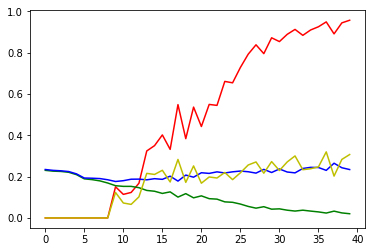

In [ ]:
torch.set_num_threads(8)
device = torch.device('cuda:0') if torch.cuda.device_count() > 0 else torch.device('cpu')

from torch.nn import CrossEntropyLoss
from torch.optim import Adam, SGD

#model = CNN()
model = CNN(embed_layer)

loss = CrossEntropyLoss()
#loss_class_weight = torch.Tensor([1, 16]).cuda()
#loss = CrossEntropyLoss(weight=loss_class_weight)

trainable_tensors = [p[1] for p in model.named_parameters() if p[0].startswith('conv') or p[0].startswith('fc')]
optimizer = Adam(params=trainable_tensors, lr=learning_rate)

from ignite.engine import create_supervised_trainer, Events, create_supervised_evaluator
from ignite.metrics import Loss, Accuracy, Precision, Recall

#from torch.optim.lr_scheduler import StepLR
#scheduler = StepLR(optimizer=optimizer, step_size=20, gamma=1.1)

trainer = create_supervised_trainer(model=model, optimizer=optimizer, loss_fn=loss, device=device)
evaluator = create_supervised_evaluator(model=model, metrics={'Loss': Loss(loss), 'Accuracy': Accuracy(), 'Precision': Precision(), 'Recall': Recall()}, device=device)
metrics = Metrics()

epoch_st = time()
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_loss(trainer):
    evaluator.run(train_dl)
    metrics.add_train(evaluator.state.metrics)
    #scheduler.step()

    global epoch_st
    elasped_time = int(time()-epoch_st)
    epoch_st = time()

    print(f"epoch {trainer.state.epoch} {evaluator.state.metrics} {elasped_time}")
    evaluator.run(val_dl)
    metrics.add_val(evaluator.state.metrics)

    if int(trainer.state.epoch) % 5 == 0:
        torch.save(model, 'model/%d'%(trainer.state.epoch))
        
    plot_metrics(metrics)

trainer.run(train_dl, max_epochs=200)

In [12]:
evaluator.run(val_dl)
evaluator.state.metrics

{'Loss': 0.171541427444028,
 'Accuracy': 0.9368731337569864,
 'Precision': tensor([0.9766, 0.4834], device='cuda:0'),
 'Recall': tensor([0.9557, 0.6441], device='cuda:0')}